In [1]:
!CUDA_VISIBLE_DEVICE=1
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
## 图像显示中文的问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)
import pandas as pd
pd.set_option("max_colwidth", 200)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
## 忽略提醒
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import anndata as ad
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
import scipy.sparse as sp_sparse
import tables

In [3]:
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,
        device='cpu',
        seed=0,
        
        hparams="",
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_all/model_seed=0_step=800000.pt'))
    return autoencoder

In [4]:
# load the real dataset
adata = sc.read_h5ad('../data/tabula_muris/all.h5ad')
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)

print(adata)
sc.pp.normalize_total(adata, target_sum=1e4)

cell_data = adata.X.toarray()

cell_data.shape

AnnData object with n_obs × n_vars = 57004 × 18996
    obs: 'celltype', 'n_genes'
    var: 'n_cells'


(57004, 18996)

In [5]:
# load the dataset that generated by scDiffusion
npzfile=np.load('../data/new_version/muris_all.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][:57000]

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all),return_decoded=True).detach().numpy()

ori = ad.AnnData(cell_gen_all, dtype=np.float32)

cell_gen = ori.X#[:3000]
cell_gen.shape

(57000, 18996)

In [6]:
full_data = np.concatenate((cell_data, cell_gen),axis=0)
full_data = ad.AnnData(full_data, dtype=np.float32)
full_data.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]\

SyntaxError: unexpected EOF while parsing (3425725412.py, line 3)

In [ ]:
adata = full_data
sc.tl.pca(adata, svd_solver='arpack')

AnnData object with n_obs × n_vars = 114004 × 18996


In [ ]:
real = adata[adata.obs_names=='true_Cell'].obsm['X_pca']
sim = adata[adata.obs_names=='gen_Cell'].obsm['X_pca']

data = np.concatenate((real,sim),axis=0)
label = np.concatenate((np.ones((real.shape[0])),np.zeros((sim.shape[0]))))

print(data.shape, label.shape)

X_train,X_val,y_train,y_val = train_test_split(data, label,
                                               test_size = 0.25,random_state = 1)
print("X_train.shape :",X_train.shape)
print("X_val.shape :",X_val.shape)

(114004, 50) (114004,)
X_train.shape : (85503, 50)
X_val.shape : (28501, 50)


In [ ]:
rfc1 = RandomForestClassifier(n_estimators = 1000, 
                              max_depth= 5,       
                              oob_score=True,
                              class_weight = "balanced",
                              random_state=1)
rfc1.fit(X_train,y_train)

rfc1_lab = rfc1.predict(X_train)
rfc1_pre = rfc1.predict(X_val)
print("random forest OOB score:",rfc1.oob_score_)
print("accuracy of training set:",accuracy_score(y_train,rfc1_lab))
print("accuracy of validation set:",accuracy_score(y_val,rfc1_pre))

随机森林的OOB score: 0.5789270551910459
训练数据集上的精度: 0.5864823456486907
验证数据集上的精度: 0.5766464334584751


findfont: Font family ['Kaiti'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Kaiti'] not found. Falling back to DejaVu Sans.


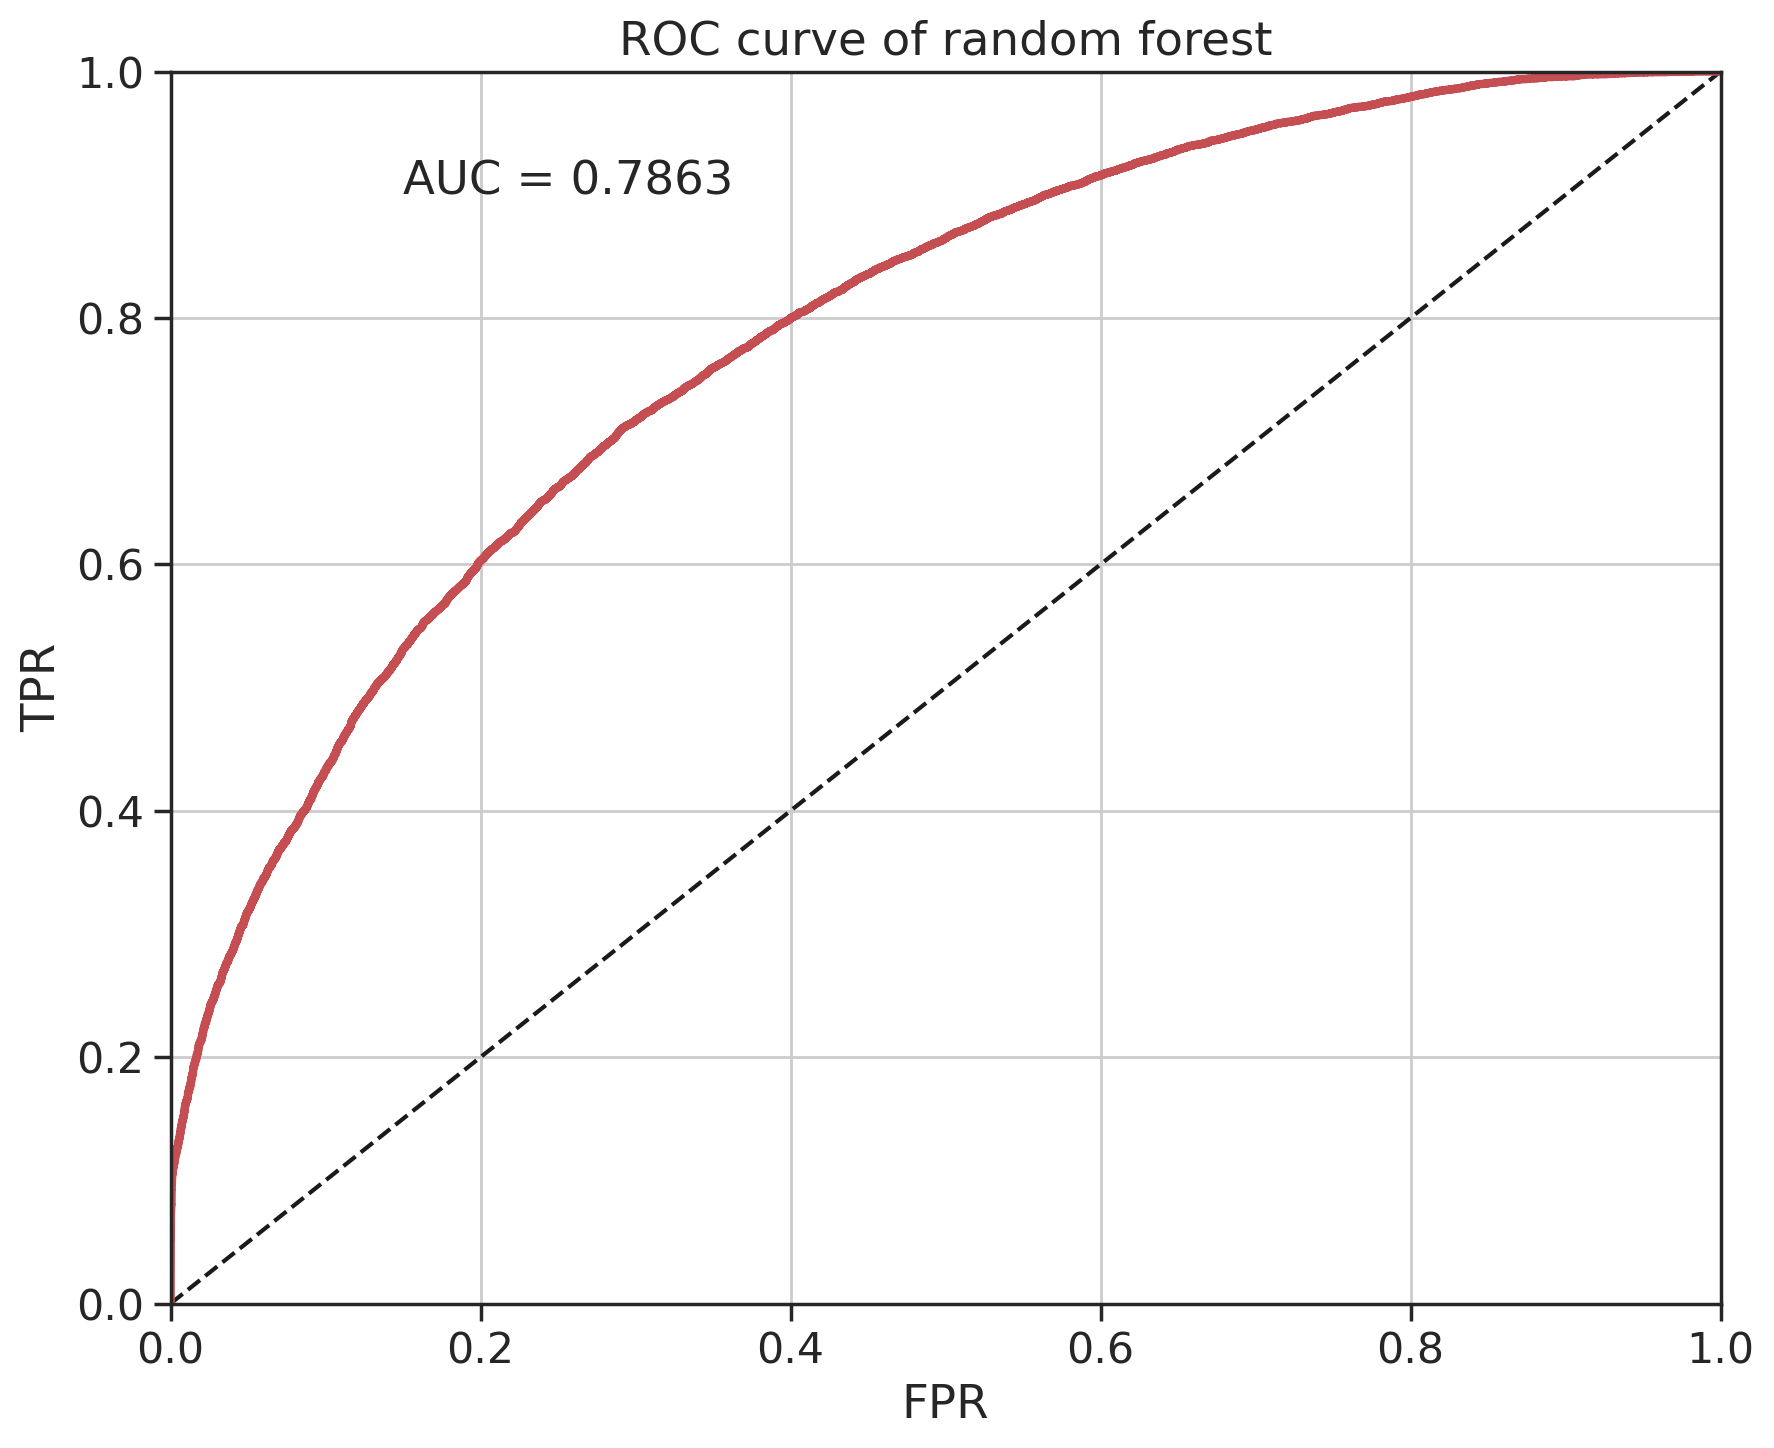

In [ ]:
pre_y = rfc1.predict_proba(X_val)[:, 1]
fpr_Nb, tpr_Nb, _ = roc_curve(y_val, pre_y)
aucval = auc(fpr_Nb, tpr_Nb)    
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve of random forest")
plt.text(0.15,0.9,"AUC = "+str(round(aucval,4)))
plt.show()